In [1]:
import numpy as np
import pandas as pd
import vectorbt as vbt

In [2]:
split_kwargs = dict(
    n=30, 
    window_len=365 * 2, 
    set_lens=(180,), 
    left_to_right=False
)  # 30 windows, each 2 years long, reserve 180 days for test
pf_kwargs = dict(
    direction='all',  # long and short
    freq='d'
)
windows = np.arange(10, 50)

In [3]:
price = vbt.YFData.download('BTC-USD').get('Close')

In [4]:
print(price)

Date
2014-09-17 00:00:00+00:00      457.334015
2014-09-18 00:00:00+00:00      424.440002
2014-09-19 00:00:00+00:00      394.795990
2014-09-20 00:00:00+00:00      408.903992
2014-09-21 00:00:00+00:00      398.821014
                                 ...     
2021-06-22 00:00:00+00:00    32505.660156
2021-06-23 00:00:00+00:00    33723.027344
2021-06-24 00:00:00+00:00    34662.437500
2021-06-25 00:00:00+00:00    31637.779297
2021-06-26 00:00:00+00:00    31375.220703
Name: Close, Length: 2471, dtype: float64


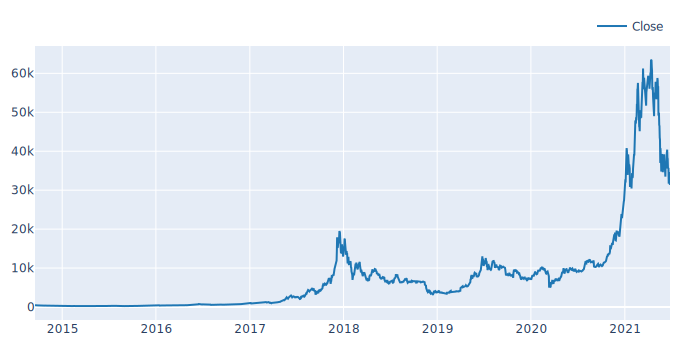

In [5]:
price.vbt.plot().show_svg()

In [6]:
def roll_in_and_out_samples(price, **kwargs):
    return price.vbt.rolling_split(**kwargs)

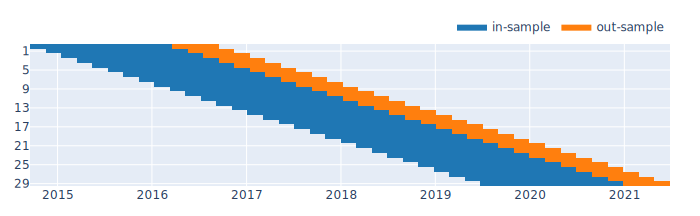

In [7]:
roll_in_and_out_samples(price, **split_kwargs, plot=True, trace_names=['in-sample', 'out-sample']).show_svg()

In [8]:
(in_price, in_indexes), (out_price, out_indexes) = roll_in_and_out_samples(price, **split_kwargs)

print(in_price.shape, len(in_indexes))  # in-sample
print(out_price.shape, len(out_indexes))  # out-sample

(550, 30) 30
(180, 30) 30


In [9]:
def simulate_holding(price, **kwargs):
    pf = vbt.Portfolio.from_holding(price, **kwargs)
    return pf.sharpe_ratio()

In [10]:
in_hold_sharpe = simulate_holding(in_price, **pf_kwargs)

print(in_hold_sharpe)

split_idx
0     0.190421
1     0.404430
2     1.348004
3     0.970856
4     1.352216
5     1.267787
6     1.896074
7     1.971474
8     1.832473
9     2.214063
10    2.401483
11    2.451095
12    2.041640
13    1.902848
14    1.427105
15    1.343899
16    1.227558
17    0.615644
18    0.262678
19    0.245356
20    0.205917
21    0.203767
22    0.278368
23    0.407743
24    0.440573
25    0.553782
26    0.959667
27    1.131913
28    1.029457
29    0.999829
Name: sharpe_ratio, dtype: float64


In [11]:
def simulate_all_params(price, windows, **kwargs):
    fast_ma, slow_ma = vbt.MA.run_combs(price, windows, r=2, short_names=['fast', 'slow'])
    entries = fast_ma.ma_above(slow_ma, crossover=True)
    exits = fast_ma.ma_below(slow_ma, crossover=True)
    pf = vbt.Portfolio.from_signals(price, entries, exits, **kwargs)
    return pf.sharpe_ratio()

In [12]:
# Simulate all params for in-sample ranges
in_sharpe = simulate_all_params(in_price, windows, **pf_kwargs)

print(in_sharpe)

fast_window  slow_window  split_idx
10           11           0            0.711982
                          1            0.887738
                          2            0.355745
                          3            0.297357
                          4            0.555029
                                         ...   
48           49           25          -0.194479
                          26          -0.004112
                          27          -0.338373
                          28          -0.904332
                          29          -0.730023
Name: sharpe_ratio, Length: 23400, dtype: float64


In [13]:
def get_best_index(performance, higher_better=True):
    if higher_better:
        return performance[performance.groupby('split_idx').idxmax()].index
    return performance[performance.groupby('split_idx').idxmin()].index

In [14]:
in_best_index = get_best_index(in_sharpe)

print(in_best_index)

MultiIndex([(27, 29,  0),
            (27, 29,  1),
            (21, 25,  2),
            (23, 25,  3),
            (20, 41,  4),
            (23, 25,  5),
            (40, 43,  6),
            (37, 43,  7),
            (37, 43,  8),
            (10, 21,  9),
            (10, 21, 10),
            (10, 21, 11),
            (10, 22, 12),
            (10, 21, 13),
            (10, 21, 14),
            (10, 22, 15),
            (10, 22, 16),
            (10, 22, 17),
            (17, 22, 18),
            (17, 22, 19),
            (13, 21, 20),
            (13, 21, 21),
            (18, 21, 22),
            (45, 49, 23),
            (18, 21, 24),
            (13, 21, 25),
            (15, 18, 26),
            (13, 20, 27),
            (13, 20, 28),
            (13, 20, 29)],
           names=['fast_window', 'slow_window', 'split_idx'])


In [15]:
def get_best_params(best_index, level_name):
    return best_index.get_level_values(level_name).to_numpy()

In [16]:
in_best_fast_windows = get_best_params(in_best_index, 'fast_window')
in_best_slow_windows = get_best_params(in_best_index, 'slow_window')
in_best_window_pairs = np.array(list(zip(in_best_fast_windows, in_best_slow_windows)))

print(in_best_window_pairs)

[[27 29]
 [27 29]
 [21 25]
 [23 25]
 [20 41]
 [23 25]
 [40 43]
 [37 43]
 [37 43]
 [10 21]
 [10 21]
 [10 21]
 [10 22]
 [10 21]
 [10 21]
 [10 22]
 [10 22]
 [10 22]
 [17 22]
 [17 22]
 [13 21]
 [13 21]
 [18 21]
 [45 49]
 [18 21]
 [13 21]
 [15 18]
 [13 20]
 [13 20]
 [13 20]]


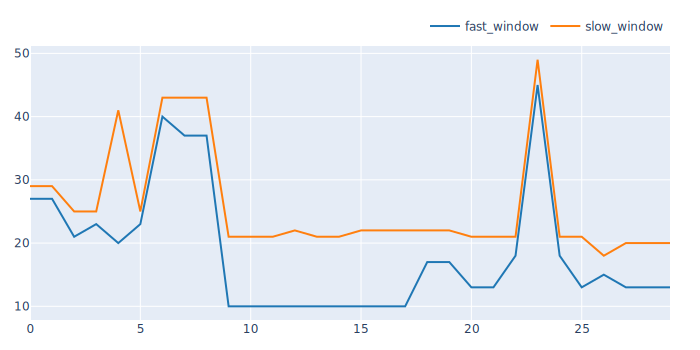

In [17]:
pd.DataFrame(in_best_window_pairs, columns=['fast_window', 'slow_window']).vbt.plot().show_svg()

In [18]:
out_hold_sharpe = simulate_holding(out_price, **pf_kwargs)

print(out_hold_sharpe)

split_idx
0     1.473802
1     1.742023
2     0.909400
3     2.507688
4     2.718833
5     2.987803
6     2.684575
7     2.843765
8     3.198760
9     1.623189
10    0.958321
11   -1.002344
12   -0.372763
13   -1.011973
14   -1.190830
15   -1.121916
16    0.020416
17    2.990761
18    2.269016
19    1.281710
20   -0.865338
21   -0.323114
22    0.294102
23    0.864560
24    0.936738
25    1.712049
26    3.618405
27    3.426252
28    3.283306
29    0.631778
Name: sharpe_ratio, dtype: float64


In [19]:
# Simulate all params for out-sample ranges
out_sharpe = simulate_all_params(out_price, windows, **pf_kwargs)

print(out_sharpe)

fast_window  slow_window  split_idx
10           11           0           -0.846291
                          1           -0.390338
                          2            0.562146
                          3            0.191306
                          4            1.904757
                                         ...   
48           49           25          -2.405009
                          26           1.203458
                          27           2.961992
                          28           2.276124
                          29           0.186799
Name: sharpe_ratio, Length: 23400, dtype: float64


In [20]:
def simulate_best_params(price, best_fast_windows, best_slow_windows, **kwargs):
    fast_ma = vbt.MA.run(price, window=best_fast_windows, per_column=True)
    slow_ma = vbt.MA.run(price, window=best_slow_windows, per_column=True)
    entries = fast_ma.ma_above(slow_ma, crossover=True)
    exits = fast_ma.ma_below(slow_ma, crossover=True)
    pf = vbt.Portfolio.from_signals(price, entries, exits, **kwargs)
    return pf.sharpe_ratio()

In [21]:
# Use best params from in-sample ranges and simulate them for out-sample ranges
out_test_sharpe = simulate_best_params(out_price, in_best_fast_windows, in_best_slow_windows, **pf_kwargs)

print(out_test_sharpe)

ma_window  ma_window  split_idx
27         29         0            0.967247
                      1           -0.220114
21         25         2            0.985761
23         25         3            1.517675
20         41         4            0.124556
23         25         5            1.511772
40         43         6            0.475062
37         43         7           -0.920504
                      8            1.174752
10         21         9            2.531840
                      10           1.551178
                      11           0.864006
           22         12           0.722613
           21         13           0.187889
                      14          -0.267001
           22         15           0.756288
                      16           1.179887
                      17           2.051936
17         22         18           0.944063
                      19          -0.567705
13         21         20          -0.477246
                      21           1.165637


In [22]:
cv_results_df = pd.DataFrame({
    'in_sample_hold': in_hold_sharpe.values,
    'in_sample_median': in_sharpe.groupby('split_idx').median().values,
    'in_sample_best': in_sharpe[in_best_index].values,
    'out_sample_hold': out_hold_sharpe.values,
    'out_sample_median': out_sharpe.groupby('split_idx').median().values,
    'out_sample_test': out_test_sharpe.values
})

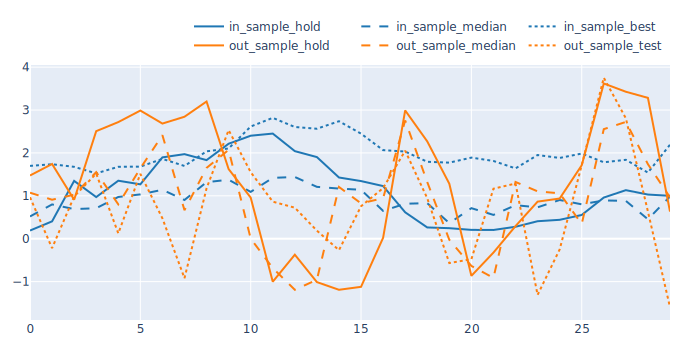

In [23]:
color_schema = vbt.settings['plotting']['color_schema']

cv_results_df.vbt.plot(
    trace_kwargs=[
        dict(line_color=color_schema['blue']),
        dict(line_color=color_schema['blue'], line_dash='dash'),
        dict(line_color=color_schema['blue'], line_dash='dot'),
        dict(line_color=color_schema['orange']),
        dict(line_color=color_schema['orange'], line_dash='dash'),
        dict(line_color=color_schema['orange'], line_dash='dot')
    ]
).show_svg()